In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array

In [2]:
dir_path = "/kaggle/input/plantdisease/PlantVillage"

In [3]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    zoom_range = 0.1,
    shear_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 25,
    validation_split = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
valid_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

train_dataset = train_datagen.flow_from_directory(
    '/kaggle/input/plantdisease/PlantVillage',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'training',
    seed = 42
)
valid_dataset = valid_datagen.flow_from_directory(
    '/kaggle/input/plantdisease/PlantVillage',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'rgb',
    subset = 'validation',
    seed = 42
)
train_dataset.class_indices

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


{'Pepper__bell___Bacterial_spot': 0,
 'Pepper__bell___healthy': 1,
 'Potato___Early_blight': 2,
 'Potato___Late_blight': 3,
 'Potato___healthy': 4,
 'Tomato_Bacterial_spot': 5,
 'Tomato_Early_blight': 6,
 'Tomato_Late_blight': 7,
 'Tomato_Leaf_Mold': 8,
 'Tomato_Septoria_leaf_spot': 9,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 10,
 'Tomato__Target_Spot': 11,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12,
 'Tomato__Tomato_mosaic_virus': 13,
 'Tomato_healthy': 14}

In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(768, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(15, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.3,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoint.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)


In [6]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=25,
    callbacks=[earlystopping, learning_rate, checkpoint]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


517/517 ━━━━━━━━━━━━━━━━━━━━ 334s 615ms/step - accuracy: 0.5592 - loss: 3.8015 - val_accuracy: 0.7855 - val_loss: 0.6550 - learning_rate: 0.0010
Epoch 2/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 209s 399ms/step - accuracy: 0.7900 - loss: 0.6493 - val_accuracy: 0.8493 - val_loss: 0.4475 - learning_rate: 0.0010
Epoch 3/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 199s 379ms/step - accuracy: 0.8418 - loss: 0.5012 - val_accuracy: 0.8758 - val_loss: 0.3989 - learning_rate: 0.0010
Epoch 4/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 194s 369ms/step - accuracy: 0.8596 - loss: 0.4385 - val_accuracy: 0.8413 - val_loss: 0.5442 - learning_rate: 0.0010
Epoch 5/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 200s 383ms/step - accuracy: 0.8701 - loss: 0.4078 - val_accuracy: 0.8950 - val_loss: 0.3196 - learning_rate: 0.0010
Epoch 6/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 191s 364ms/step - accuracy: 0.8758 - loss: 0.3947 - val_accuracy: 0.8806 - val_loss: 0.3670 - learning_rate: 0.0010
Epoch 7/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 189s 360ms/step - accuracy: 0.8811 

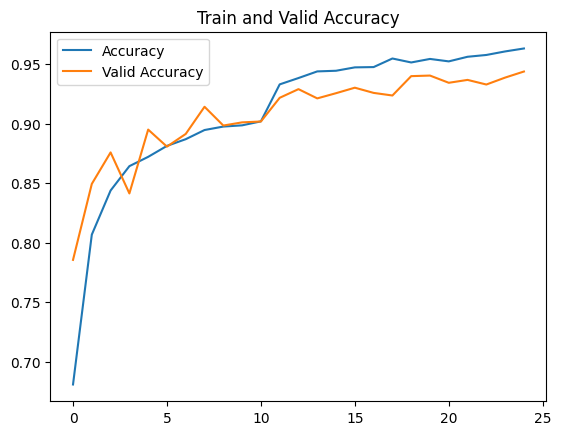

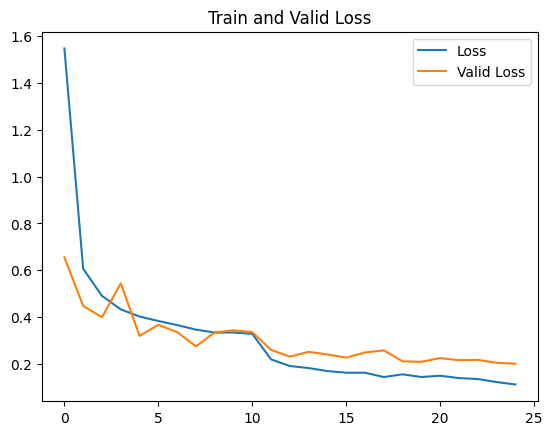

In [7]:
plt.figure()
plt.title('Train and Valid Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Valid Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


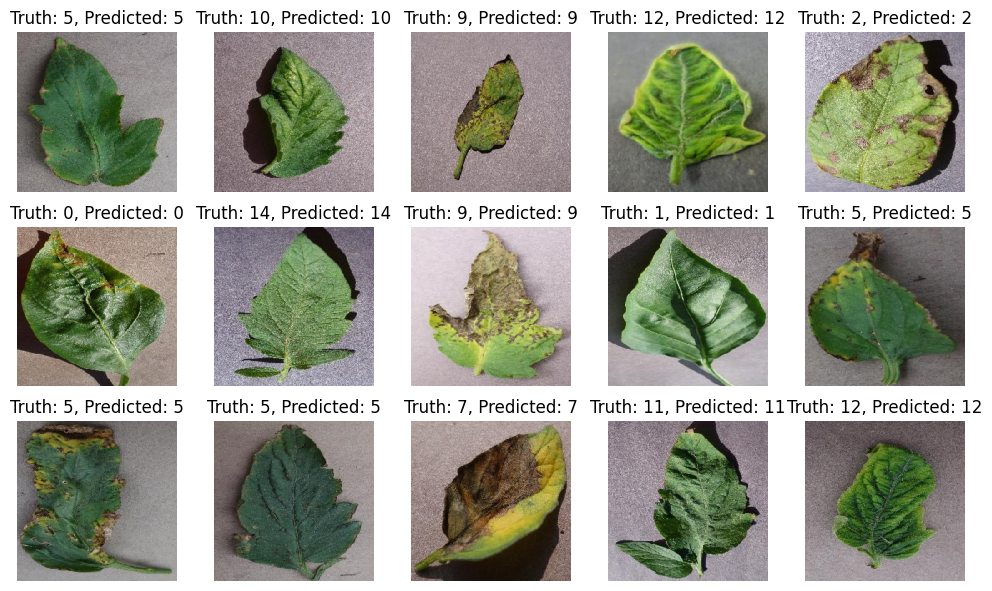

In [8]:
images, labels = next(valid_dataset)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    img = images[i]
    image = img_to_array(img)
    image = tf.expand_dims(image, axis=0)
    label = np.argmax(labels[i])
    predict = model.predict(image)[0].argmax()
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Truth: {label}, Predicted: {predict}')

plt.tight_layout()
plt.show()